# [ Crop Image ]

## local peak detection library 설치

In [ ]:
pip install peakdetect

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from peakdetect import peakdetect
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd

## Drive mount 후 경로 이동

In [7]:
cd drive/Shareddrives/KOHI_의료영상1팀/

/content/drive/Shareddrives/KOHI_의료영상1팀


### label dir 접근

In [ ]:
import os

scoliosis_label_dir = 'Data/labeled-scoliosis'
normal_label_dir = 'Data/labeled-normal'

save_path = 'Data/labeled-final'

label_dirs = [scoliosis_label_dir, normal_label_dir]
print(label_dirs)

['Data/labeled-scoliosis', 'Data/labeled-normal']


### Dataloader +) mean, std, 평균 width/height 획득

In [ ]:
normal_dataset = []
scoliosis_dataset = []

height_list = []
width_list = []
total_mean = []
total_std = []

## 원본 영상

In [ ]:
# for label_dir in label_dirs:
#   dirs = os.listdir(label_dir)
#   print(f'Get {label_dir} files...')
#   for dir in tqdm(dirs):
#     present_dir = os.path.join(label_dir, dir)
#     try:
#       png = glob.glob(os.path.join(present_dir, "*.png"))[0]
#     except:
#       print(f'{dir} - no png file!')
#     vertebrae_image = cv.imread(png)
#     vertebrae_image = cv.cvtColor(vertebrae_image, cv.COLOR_BGR2GRAY)
#     # histogram equalization(CLAHE)  
#     clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
#     vertebrae_image = clahe.apply(vertebrae_image)
    
#     try:
#       tiff = glob.glob(os.path.join(present_dir, "*.tiff"))[0]
#     except:
#       print(f'{dir} - no tiff file!')
    
#     tiff_image = cv.imread(tiff)
#     tiff_image = cv.cvtColor(tiff_image, cv.COLOR_BGR2GRAY)
#     tiff_image = cv.bitwise_not(tiff_image)
#     kernel = np.ones((3, 3), np.uint8)
#     tiff_image = cv.dilate(tiff_image, kernel, iterations=80)
    
#     if label_dir == scoliosis_label_dir:
#       scoliosis_dataset.append({'name': dir, 'input':vertebrae_image, 'label':tiff_image})
#     elif label_dir == normal_label_dir:
#       normal_dataset.append({'name': dir, 'input':vertebrae_image, 'label':tiff_image})

#     height, width = vertebrae_image.shape

#     total_mean.append(vertebrae_image.mean())
#     total_std.append(vertebrae_image.std())

#     height_list.append(height)
#     width_list.append(width)

## Dehazing 영상


In [18]:
import os

In [5]:
# input_list = os.listdir(image_dir)

FileNotFoundError: ignored

In [20]:
from tqdm import tqdm
import cv2 as cv

In [21]:

dataset = []
total_mean = []
total_std=[]


for input in tqdm(input_list):
  image = os.path.join(image_dir, input)
  vertebrae_image = cv.imread(image)
  vertebrae_image = cv.cvtColor(vertebrae_image, cv.COLOR_BGR2GRAY)
  clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
  vertebrae_image = clahe.apply(vertebrae_image)
  
  label = os.path.join(mask_dir, input)

  total_mean.append(vertebrae_image.mean())
  total_std.append(vertebrae_image.std())

  dataset.append({'name': input[:-4], 'image_path':image, 'label_path':label})


  0%|          | 0/220 [00:19<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
import numpy as np

In [ ]:
# mean_h = np.mean(height_list)
# mean_w = np.mean(width_list)
mean = np.mean(total_mean)
std = np.mean(total_std)

# center_col = mean_w/2

# print(mean_h)
# print(mean_w)
print(mean)
print(std)

114.49671173011765
70.03779196379139


# Get Spine ROI

In [ ]:
# 히스토그램 local minima
row_ratio = 0.15
col_ratio = 0.08

save_path = './이승아/result/Preprocessing/Crop-Dehazing'

def get_crop_range(dataset):
  count = 0
  for data in dataset:
    name = data['name']
    input = data['input']
    label = data['label']
    row, col = input.shape 

    # label pixel 시작점/끝점 row 위치 저장
    row_start = (cv.findNonZero(label)[0])[0][1]
    row_end = (cv.findNonZero(label)[-1])[0][1]

    
    # Col에 대한 histogram 계산
    horizontal_hist = calc_histogram(data)

    # histogram에서 local maxima 획득
    col_maxima = get_local_maxima(horizontal_hist, lookahead=200, size=col)

    # 영상의 width에 따른 maxima에 대한 crop +/- range 계산
    col_threshold = int(col * col_ratio)
    col_start = col_maxima[0][0]
    col_end = col_maxima[2][0]

    
    plt.figure(figsize=(21, 7))  
    plt.subplot(131)
    plt.plot(horizontal_hist, linewidth=3)
    plt.scatter(col_maxima[0][0],col_maxima[0][1], color='r', s = 50)
    plt.scatter(col_maxima[1][0],col_maxima[1][1], color='r', s = 50)
    plt.scatter(col_maxima[2][0],col_maxima[2][1], color='r', s = 50)

    # 영상 crop
    cropped_input = input[row_start:row_end, col_start:col_end]
    cropped_label = label[row_start:row_end, col_start:col_end]

    # Overlay한 결과 출력
    plt.imshow(input, cmap='gray')
    plt.title('input')

    plt.subplot(132)
    plt.imshow(cropped_input, cmap='gray')
    plt.title('Cropped')

    plt.subplot(133)
    plt.imshow(cropped_input, cmap='gray')
    plt.imshow(cropped_label, cmap='gray', interpolation='none', alpha=0.5)
    plt.title('Overlapped')
    
    plt.figure().clear()

    plt.savefig(os.path.join(save_path, name+'.png'), pad_inches=0.1)

def get_max_peak(peaks):
  sorted_peaks = sorted(peaks, key=lambda x: (x[1]), reverse=True)
  maxima_2 = sorted_peaks[0]

  # local maxima 기준 가장 큰 오른쪽 local maxima
  for idx, peak in enumerate(sorted_peaks):
    if peak[0] > maxima_2[0]:
      maxima_3 = peak
      break

  # local maxima 기준 가장 큰 왼쪽 local maxima
  for idx, peak in enumerate(sorted_peaks):
    if peak[0] < maxima_2[0]:
      maxima_1 = peak
      break

  return [maxima_1, maxima_2, maxima_3]

def get_local_maxima(hist, lookahead, size):
  peaks = sum(peakdetect(hist, lookahead=lookahead), [])

  size_threshold = size * col_ratio

  peaks.sort(key=lambda x:x[0])     # col index에 따라 오름차순
  max_peak = get_max_peak(peaks)
  

  # return [max_peak[0][0], max_peak[2][0]]   
  return max_peak

def calc_histogram(data):
  input = data['input']
  _, width = input.shape
  
  img_col_sum = np.sum(input, axis=0).tolist()
  img_col_sum = [x / width for x in img_col_sum]
  
  return img_col_sum

# get_crop_range(scoliosis_dataset)
get_crop_range(dataset)

## spicy로 peak detect

In [ ]:
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

In [ ]:
%matplotlib inline

In [ ]:
# 히스토그램 local minima
row_ratio = 0.15
col_ratio = 0.2

save_path = './이승아/result/Preprocessing/Crop-Dehazing'

def get_crop_range(dataset):
  count = 0
  for data in tqdm(dataset):
    name = data['name']
    input = data['input']
    label = data['label']
    row, col = input.shape 

    # label pixel 시작점/끝점 row 위치 저장
    row_start = (cv.findNonZero(label)[0])[0][1]
    row_end = (cv.findNonZero(label)[-1])[0][1]

    
    # Col에 대한 histogram 계산
    horizontal_hist = np.array(calc_histogram(data))

    # histogram에서 local maxima 획득
    col_maxima = get_local_maxima(horizontal_hist, size=col)

    # 영상의 width에 따른 maxima에 대한 crop +/- range 계산
    col_threshold = int(col * col_ratio)
    col_start = col_maxima[0]
    col_end = col_maxima[1]
    
    plt.figure(figsize=(21, 7))  
    plt.subplot(131)
    plt.plot(horizontal_hist, linewidth=3)
    plt.plot(col_maxima, horizontal_hist[col_maxima], 'x')

    # 영상 crop
    cropped_input = input[row_start:row_end, col_start:col_end]
    cropped_label = label[row_start:row_end, col_start:col_end]

    # Overlay한 결과 출력
    plt.imshow(input, cmap='gray')
    plt.title('input')

    plt.subplot(132)
    plt.imshow(cropped_input, cmap='gray')
    plt.title('Cropped')

    plt.subplot(133)
    plt.imshow(cropped_input, cmap='gray')
    plt.imshow(cropped_label, cmap='gray', interpolation='none', alpha=0.5)
    plt.title('Overlapped')

    plt.savefig(os.path.join(save_path, name+'.png'), pad_inches=0.1)

    # count = count +1
    # if count == 15:
    #   break

def get_local_maxima(hist, size):
  
  peaks, _ = find_peaks(hist, distance=150)
  
  size_threshold = size * col_ratio
  peaks = [x for x in peaks if x > size_threshold and x < size-size_threshold]
  
  if len(peaks) > 3:
    max_index = np.argmax(peaks[1:-1])
    return [peaks[0], peaks[-1]]
  return peaks

def calc_histogram(data):
  input = data['input']
  _, width = input.shape
  
  img_col_sum = np.sum(input, axis=0).tolist()
  img_col_sum = [x / width for x in img_col_sum]
  
  return img_col_sum

# get_crop_range(scoliosis_dataset)
get_crop_range(dataset)

In [ ]:
# # 히스토그램 local minima
# row_ratio = 0.15
# col_ratio = 0.15

# save_path = './이승아/result/Preprocessing/Crop-Dehazing'

# def get_crop_range(dataset):
#   count = 0
#   for data in tqdm(dataset):
#     name = data['name']
#     input = data['input']
#     label = data['label']
#     row, col = input.shape 

#     # label pixel 시작점/끝점 row 위치 저장
#     row_start = (cv.findNonZero(label)[0])[0][1]
#     row_end = (cv.findNonZero(label)[-1])[0][1]

    
#     # Col에 대한 histogram 계산
#     horizontal_hist = calc_histogram(data)

#     # histogram에서 local maxima 획득
#     col_maxima = get_local_maxima(horizontal_hist, lookahead=100, size=col)

#     # 영상의 width에 따른 maxima에 대한 crop +/- range 계산
#     col_threshold = int(col * col_ratio)
#     col_start = col_maxima-col_threshold
#     col_end = col_maxima+col_threshold

#     # 영상 crop
#     cropped_input = input[row_start:row_end, col_start:col_end]
#     cropped_label = label[row_start:row_end, col_start:col_end]

#     # Overlay한 결과 출력
#     plt.figure(figsize=(21, 7))  
#     plt.subplot(131)
#     plt.imshow(input, cmap='gray')
#     plt.title('input')

#     plt.subplot(132)
#     plt.imshow(cropped_input, cmap='gray')
#     plt.title('Cropped')

#     plt.subplot(133)
#     plt.imshow(cropped_input, cmap='gray')
#     plt.imshow(cropped_label, cmap='gray', interpolation='none', alpha=0.5)
#     plt.title('Overlapped')
    
#     plt.figure().clear()

#     plt.savefig(os.path.join(save_path, name+'.png'), pad_inches=0.1)

#     count = count + 1
#     if count == 5:
#       break

# def get_max_peak(peaks):
#   # max = -1
#   # max_peak = None
#   # for idx, peak in enumerate(peaks):
#   #   if peak[1] > max:
#   #     max = peak[1]
#   #     max_peak = peak
#   # print(peaks)
#   print(sorted(peaks, key=lambda x: (x[1]), reverse=True))
#   max_peak =sorted(peaks, key=lambda x: (x[1]), reverse=True)[:3]
#   return max_peak

# def get_local_maxima(hist, lookahead, size):
#   peaks = sum(peakdetect(hist, lookahead=lookahead), [])

#   size_threshold = size * col_ratio

#   peaks.sort(key=lambda x:x[0])     # col index에 따라 오름차순
#   # 극대점이 col의 boundary쪽으로 빠지는 것 처리
#   # peaks = [x for x in peaks if x[0] > size_threshold and x[0] < size-size_threshold]
#   peaks = [x for x in peaks if x[0] > 100 and x[0] < size-100]
#   max_peak = get_max_peak(peaks)
  
#   plt.plot(hist)
#   plt.scatter(max_peak[0][0],max_peak[0][1], color='r')
#   plt.scatter(max_peak[1][0],max_peak[1][1], color='r')
#   plt.scatter(max_peak[2][0],max_peak[2][1], color='r')
#   # plt.scatter(max_peak[0]-size_threshold,max_peak[1], color='r')
#   # plt.scatter(max_peak[0]+size_threshold,max_peak[1], color='r')
#   plt.figure().clear()
  
#   return int(max_peak[0])     # int64로 반환되는거 형 변환

# def calc_histogram(data):
#   input = data['input']
#   _, width = input.shape
  
#   img_col_sum = np.sum(input, axis=0).tolist()
#   img_col_sum = [x / width for x in img_col_sum]
  
#   return img_col_sum

# # get_crop_range(scoliosis_dataset)
# get_crop_range(dataset)

# Padding

  0%|          | 0/12 [00:00<?, ?it/s]


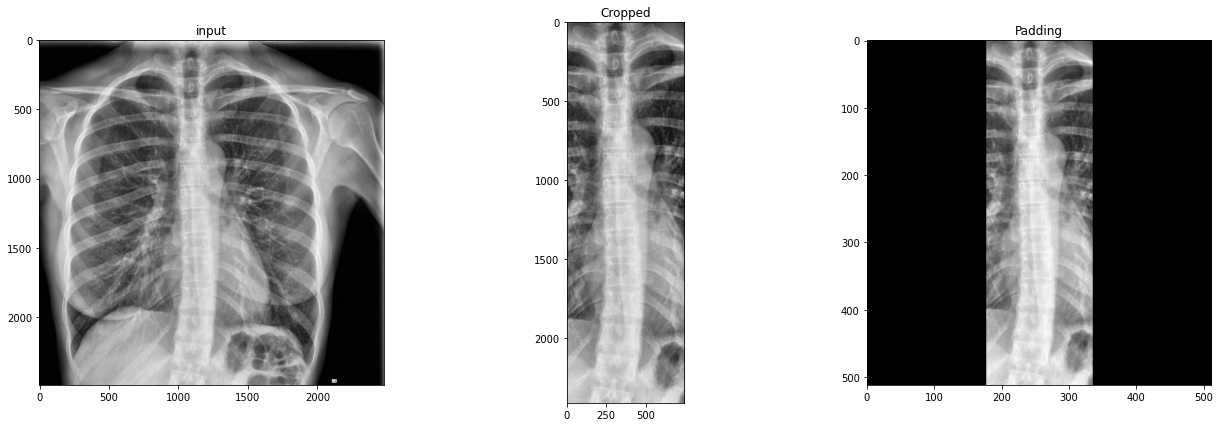

In [ ]:
# get vertebrae ROI 
def crop_roi(input, label):
  _, col = input.shape 

  # label pixel 시작점/끝점 row 위치 저장
  row_start = (cv.findNonZero(label)[0])[0][1]
  row_end = (cv.findNonZero(label)[-1])[0][1]

  # Col에 대한 histogram 계산
  horizontal_hist = calc_histogram(input)

  # histogram에서 local maxima 획득
  col_maxima = get_local_maxima(horizontal_hist, lookahead=100, size=col)

  # 영상의 width에 따른 maxima에 대한 crop +/- range 계산
  col_threshold = int(col * col_ratio)
  col_start = col_maxima-col_threshold
  col_end = col_maxima+col_threshold

  # 영상 crop
  cropped_input = input[row_start:row_end, col_start:col_end]
  cropped_label = label[row_start:row_end, col_start:col_end]

  plt.figure(figsize=(21, 7))  
  plt.subplot(131)
  plt.imshow(input, cmap='gray')
  plt.title('input')

  plt.subplot(132)
  plt.imshow(cropped_input, cmap='gray')
  plt.title('Cropped')


  return cropped_input, cropped_label

# 극대점 획득
def get_max_peak(peaks):
  max = -1
  max_peak = None
  for idx, peak in enumerate(peaks):
    if peak[1] > max:
      max = peak[1]
      max_peak = peak
  return max_peak

def get_local_maxima(hist, lookahead, size):
  peaks = sum(peakdetect(hist, lookahead=lookahead), [])

  size_threshold = size * col_ratio

  peaks.sort(key=lambda x:x[0])     # col index에 따라 오름차순
  # 극대점이 col의 boundary쪽으로 빠지는 것 처리
  peaks = [x for x in peaks if x[0] > size_threshold and x[0] < size-size_threshold]
  max_peak = get_max_peak(peaks)
  
  return int(max_peak[0])     # int64로 반환되는거 형 변환

# 히스토그램 생성
def calc_histogram(input):
  _, width = input.shape
  
  img_col_sum = np.sum(input, axis=0).tolist()
  img_col_sum = [x / width for x in img_col_sum]
  
  return img_col_sum


def resize_image(input, label):
  r = image_size / input.shape[0]
  dim = (int(input.shape[1] * r), image_size)

  resized_input = cv.resize(input, dim, interpolation = cv.INTER_AREA)
  resized_label = cv.resize(label, dim, interpolation = cv.INTER_NEAREST)
  
  return resized_input, resized_label

def padding_image(input, label):
  input_size = input.shape
  target_size = (image_size, image_size)
  padding_range = int(target_size[1]-input_size[1])

  if padding_range%2 == 0:
    padding_size = (int(padding_range/2), int(padding_range/2))
  else:
    padding_size = (int(padding_range/2), int(padding_range/2)+1)
  
  npad= ((0,0),padding_size)
  padding_input = np.pad(input, npad,'constant', constant_values=(0))
  padding_label = np.pad(label, npad,'constant', constant_values=(0))

  plt.subplot(133)
  plt.imshow(padding_input, cmap='gray')
  plt.title('Padding')
  
  return padding_input, padding_label

for data in tqdm(scoliosis_dataset):
    name = data['name']
    input = data['input']
    label = data['label']
    row, col = input.shape 

    # Resize and pad Image
    input, label = crop_roi(input, label)
    input, label = resize_image(input, label)
    input, label = padding_image(input, label)

    break

# [ Save Dehazing Image ]

In [22]:
!pip install image_dehazer

     |████████████████████████████████| 14.6 MB 7.3 MB/s 
  Created wheel for image-dehazer: filename=image_dehazer-0.0.5-py3-none-any.whl size=5337 sha256=b873f98e58032b78706dbd0b84c860e3c38e1d9ed02d6111f2ae1581b88a840a
  Stored in directory: /root/.cache/pip/wheels/1f/df/91/5f397926c032bd3a2f67bf771bfa1c555e67fe8877814c926e
Successfully built image-dehazer
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.19.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [30]:
import os
import image_dehazer
import matplotlib.pyplot as plt


In [26]:
scoliosis_dir = os.listdir('Data/CheXpert/scoliosis')[:-1]
normal_dir = os.listdir('Data/CheXpert/normal')
image_list = scoliosis_dir + normal_dir
len(image_list)

220

In [27]:
evaluation = 'CheXpert'
save_path = f'External Validation/{evaluation}/dehazing'

In [34]:
for image in tqdm(scoliosis_dir) :
  input = cv.imread(os.path.join('Data/CheXpert/scoliosis', image))
  # print(os.path.join('Data/CheXpert/scoliosis', image))
  # plt.imshow(input)

  output = image_dehazer.remove_haze(input)

  cv.imwrite(os.path.join(save_path, image), output)

100%|██████████| 100/100 [1:08:25<00:00, 41.05s/it]


In [35]:
for image in tqdm(normal_dir) :
  input = cv.imread(os.path.join('Data/CheXpert/normal', image))
  # print(os.path.join('Data/CheXpert/scoliosis', image))
  # plt.imshow(input)

  output = image_dehazer.remove_haze(input)

  cv.imwrite(os.path.join(save_path, image), output)

100%|██████████| 120/120 [1:21:56<00:00, 40.97s/it]


In [36]:
len(os.listdir(save_path))

220

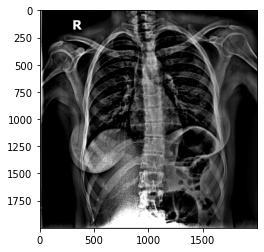

In [ ]:
plt.imshow(output, cmap='gray')

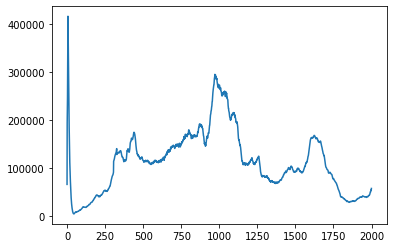

In [ ]:
img_col_sum = np.sum(output, axis=0).tolist()

plt.plot(img_col_sum)

# [ Save labeled data information to csv file ]
name도 함께 수정하려고 하였으나 '1 (46)'과 같은 파일들의 원본 네임을 모르므로 일단 생략


In [ ]:
import pandas as pd

In [ ]:
categories = ['scoliosis', 'normal']

var_list = ['ImageID', 'ImageDir', 'Age', 'Sex_binary', 'WindowCenter_DICOM', 'WindowWidth_DICOM', 'Labels']

df_normal = pd.read_csv(f'Data/PadChest/Labels (18세 이상 40세 미만 normal).csv')
df_normal = df_normal[var_list]
df_scoliosis = pd.read_csv(f'Data/PadChest/Labels (18세 이상 40세 미만 scoliosis).csv')
df_scoliosis = df_scoliosis[var_list]

### Create empty dataframe

In [ ]:
final_df = pd.DataFrame([], columns=var_list)

In [ ]:
count = 1

for category in categories:
  print(category)
  if category == 'scoliosis':
    dataset = scoliosis_dataset
    df = df_scoliosis
  elif category == 'normal':
    dataset = normal_dataset
    df = df_normal
    
  for data in dataset:
    if count < 56:
      count +=1
      continue
      
    name = data['name']+'.png'

    final_df = final_df.append(df[df['ImageID'] == name], ignore_index=True)

final_df.to_csv('Data/PadChestV2/labeled-final.csv', index=False)


scoliosis
normal


# 서울삼성병원 Dehazing



In [ ]:
cd drive/Shareddrives/KOHI_의료영상1팀/

[Errno 2] No such file or directory: 'drive/Shareddrives/KOHI_의료영상1팀/'
/content/drive/Shareddrives/KOHI_의료영상1팀


In [ ]:
!pip install image_dehazer

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import image_dehazer
from tqdm import tqdm

dataset_path = 'External Validation/samsung-hospital/origin'
save_path = 'External Validation/samsung-hospital/dehazing'
dataset = os.listdir(dataset_path)

In [ ]:
count = 1
for data in tqdm(dataset):
  save_dir = os.path.join(save_path, data)
  if not os.path.isdir(save_dir):
      os.mkdir(save_dir)
  else:
    continue
  
  image_list = os.listdir(os.path.join(dataset_path,data))
  for image in image_list:
    image_path = os.path.join(dataset_path,data, image)
    
    origin_image  = cv.imread(image_path)
    dehazing_image = image_dehazer.remove_haze(origin_image)

    cv.imwrite(os.path.join(save_dir, image), dehazing_image)

100%|██████████| 100/100 [05:11<00:00,  3.12s/it]


In [ ]:
len(os.listdir(dataset_path))

100

# CheXpert Dehazing

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import image_dehazer
from tqdm import tqdm

dir_sort = ['scoliosis', 'normal']
dataset_path = 'Data/CheXpert'
save_path = 'External Validation/CheXpert/dehazing'

> scoliosis---------------------------------


100%|██████████| 100/100 [1:16:27<00:00, 45.88s/it]


> normal---------------------------------


100%|██████████| 120/120 [1:35:19<00:00, 47.66s/it]


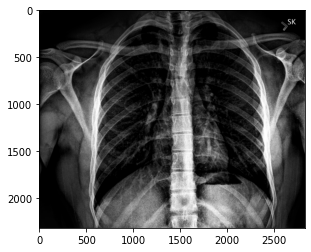

In [ ]:
for dir in dir_sort:
  print(f'> {dir}---------------------------------')
  dataset_dir = os.path.join(dataset_path, dir)
  image_list = os.listdir(dataset_dir)
  # extra 디렉터리 제외
  if 'extra' in image_list: image_list.remove('extra')

  for image in tqdm(image_list):
    image_path = os.path.join(dataset_dir, image)

    origin_image  = cv.imread(image_path)
    save_dir = os.path.join(save_path, dir)

    dehazing_image = image_dehazer.remove_haze(origin_image)
    plt.imshow(dehazing_image)
    cv.imwrite(os.path.join(save_dir, image), dehazing_image)

In [ ]:
for dir in dir_sort:
  dataset_dir = os.path.join(save_path, dir)
  
  print(dataset_dir)
  print(len(os.listdir(dataset_dir)))

External Validation/CheXpert/dehazing/scoliosis
100
External Validation/CheXpert/dehazing/normal
120
